In [68]:
import geopandas as gpd
import pandas as pd
import ee
import numpy as np
from scipy.stats import linregress, gaussian_kde
from src.data import mtbs
from src.data import raster
from src.data import pd_utils
from src.data import gedi_pipeline
from src.visualization.gedi_viz import geo_plot
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from src.data import k_nn

sns.set_theme()

import importlib
importlib.reload(raster)
importlib.reload(gedi_pipeline)
importlib.reload(k_nn)

2023-05-21 09:27:08,253 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.k_nn' from '/home/jk871/fire-regen/src/data/k_nn.py'>

In [60]:
#clustering = pd.read_csv(f'/maps/fire-regen/data/clustering/sierras_terrain_clustering_results.csv', index_col=0)
clustering = pd.read_csv(f'/maps/fire-regen/data/clustering/sierras_terrain_clustering_elevation_results.csv', index_col=0)

In [45]:
clustering.columns

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'beam_type',
       'sensitivity', 'pft_class', 'geometry', 'burn_severity_median',
       'burn_year_median', 'burn_counts_median', 'gedi_year', 'gedi_month',
       'time_since_burn', 'elevation_2x2', 'elevation_mean', 'elevation_std',
       'elevation_median', 'slope_2x2', 'slope_mean', 'slope_std',
       'slope_median', 'aspect_2x2', 'aspect_mean', 'aspect_std',
       'aspect_median', 'soil_2x2', 'soil_mean', 'soil_std', 'soil_median',
       'cluster'],
      dtype='object')

In [61]:
gedi_burned_trees = clustering[clustering.burn_severity_median != 0]
gedi_unburned_trees = clustering[clustering.burn_severity_median == 0]

In [62]:
gedi_burned_trees = gedi_pipeline.add_time_since_burn_categories(gedi_burned_trees)

In [63]:
gedi_burned_trees = gpd.GeoDataFrame(gedi_burned_trees, geometry=gpd.points_from_xy(gedi_burned_trees.lon_lowestmode, gedi_burned_trees.lat_lowestmode), crs=4326)

In [64]:
gedi_unburned_trees = gpd.GeoDataFrame(gedi_unburned_trees, geometry=gpd.points_from_xy(gedi_unburned_trees.lon_lowestmode, gedi_unburned_trees.lat_lowestmode), crs=4326)

### Take a look at terrain variables for each "time since burn"

(0.0, 400.0)

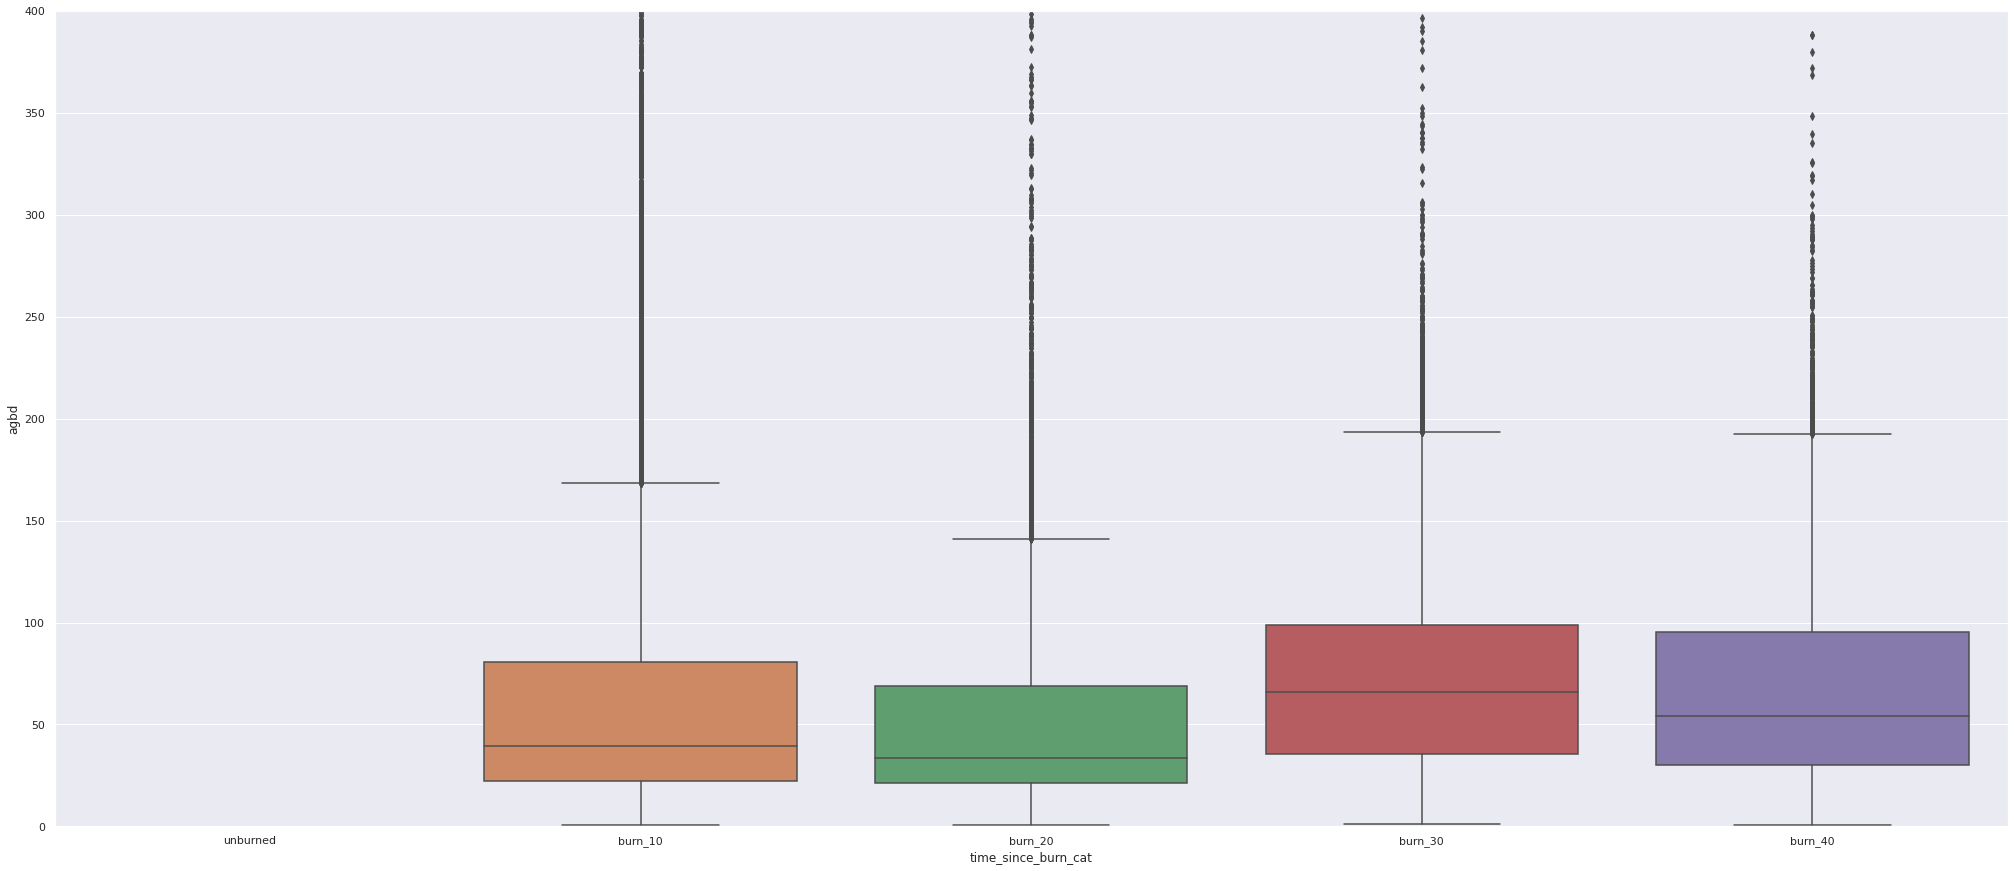

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_burned_trees[gedi_burned_trees.burn_severity_median==4], x='time_since_burn_cat', y="agbd", ax=ax)
ax.set_ylim((0,400))

### NN matching

gedi_burned_trees.cluster.unique()

In [37]:
gedi_burned_trees.cluster.unique()

array([1, 3, 0, 4, 2])

In [69]:
burned = []
for cluster_idx in range(5):
    print(f'Processing cluster {cluster_idx}')
    burned_cluster = gedi_burned_trees[gedi_burned_trees.cluster==cluster_idx]
    unburned_cluster = gedi_unburned_trees[gedi_unburned_trees.cluster==cluster_idx]
    nn_indeces, nn_distances, nn_avg_agbd = k_nn.nearest_neighbors(burned_cluster, unburned_cluster, 'agbd', 10)
    burned_cluster['rel_agbd'] = burned_cluster.agbd / nn_avg_agbd
    burned.append(burned_cluster.copy())

result = pd.concat(burned)

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4


<AxesSubplot: xlabel='time_since_burn', ylabel='rel_agbd'>

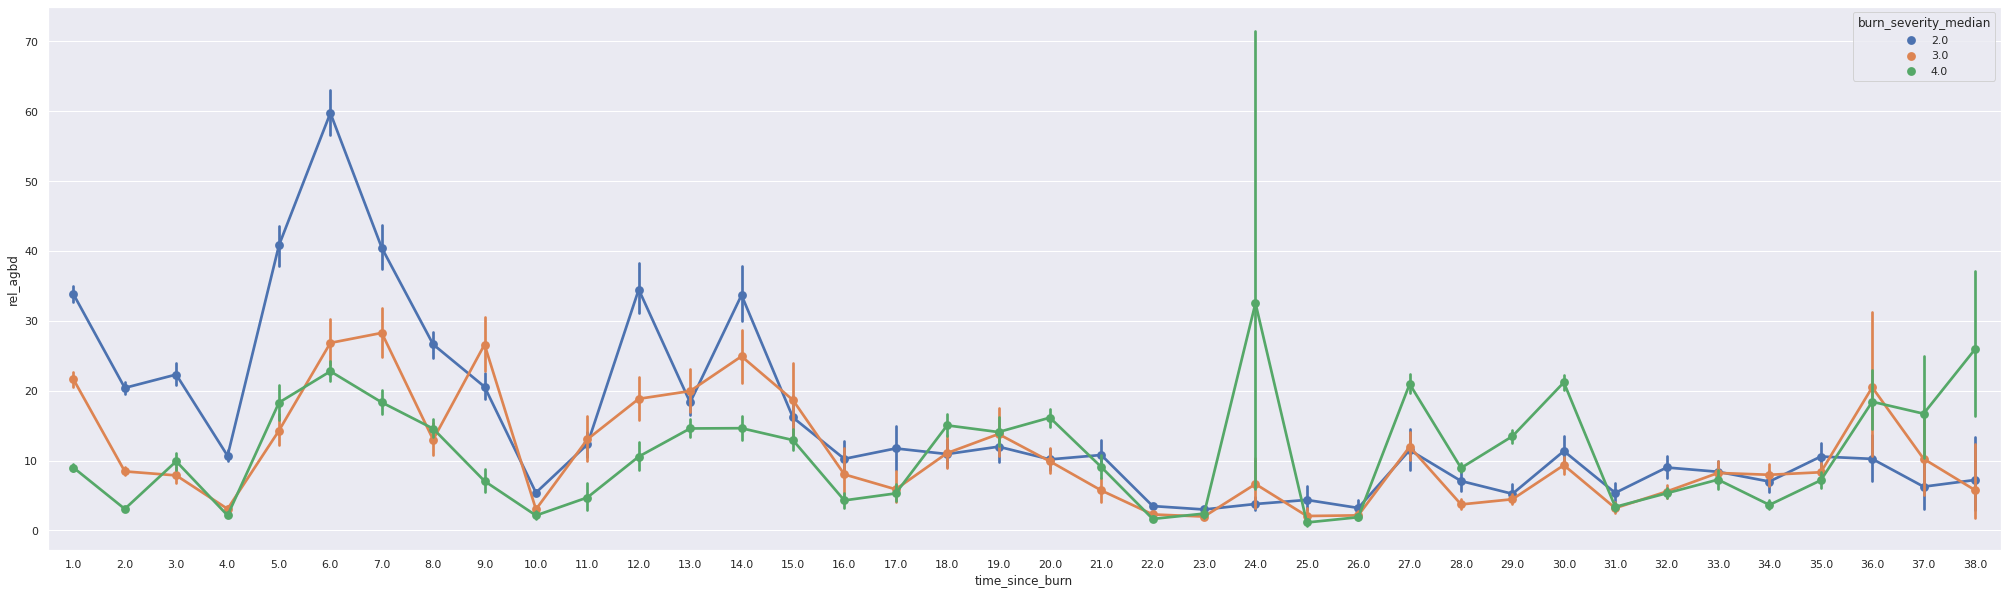

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(result, x='time_since_burn', y='rel_agbd', hue='burn_severity_median')

<AxesSubplot: xlabel='time_since_burn', ylabel='rel_agbd'>

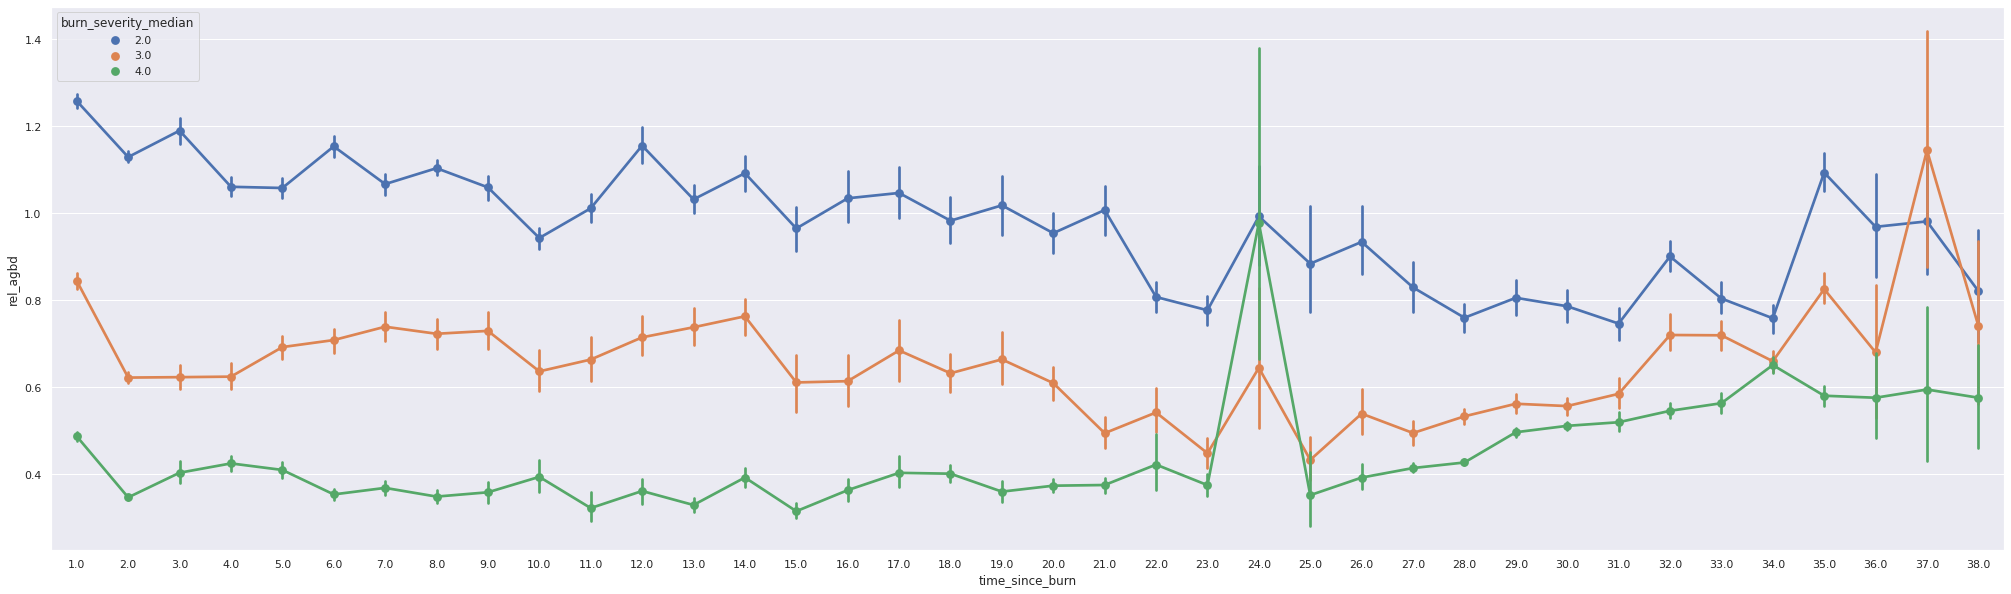

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(result, x='time_since_burn', y='rel_agbd', hue='burn_severity_median')

<AxesSubplot: xlabel='time_since_burn', ylabel='elevation_mean'>

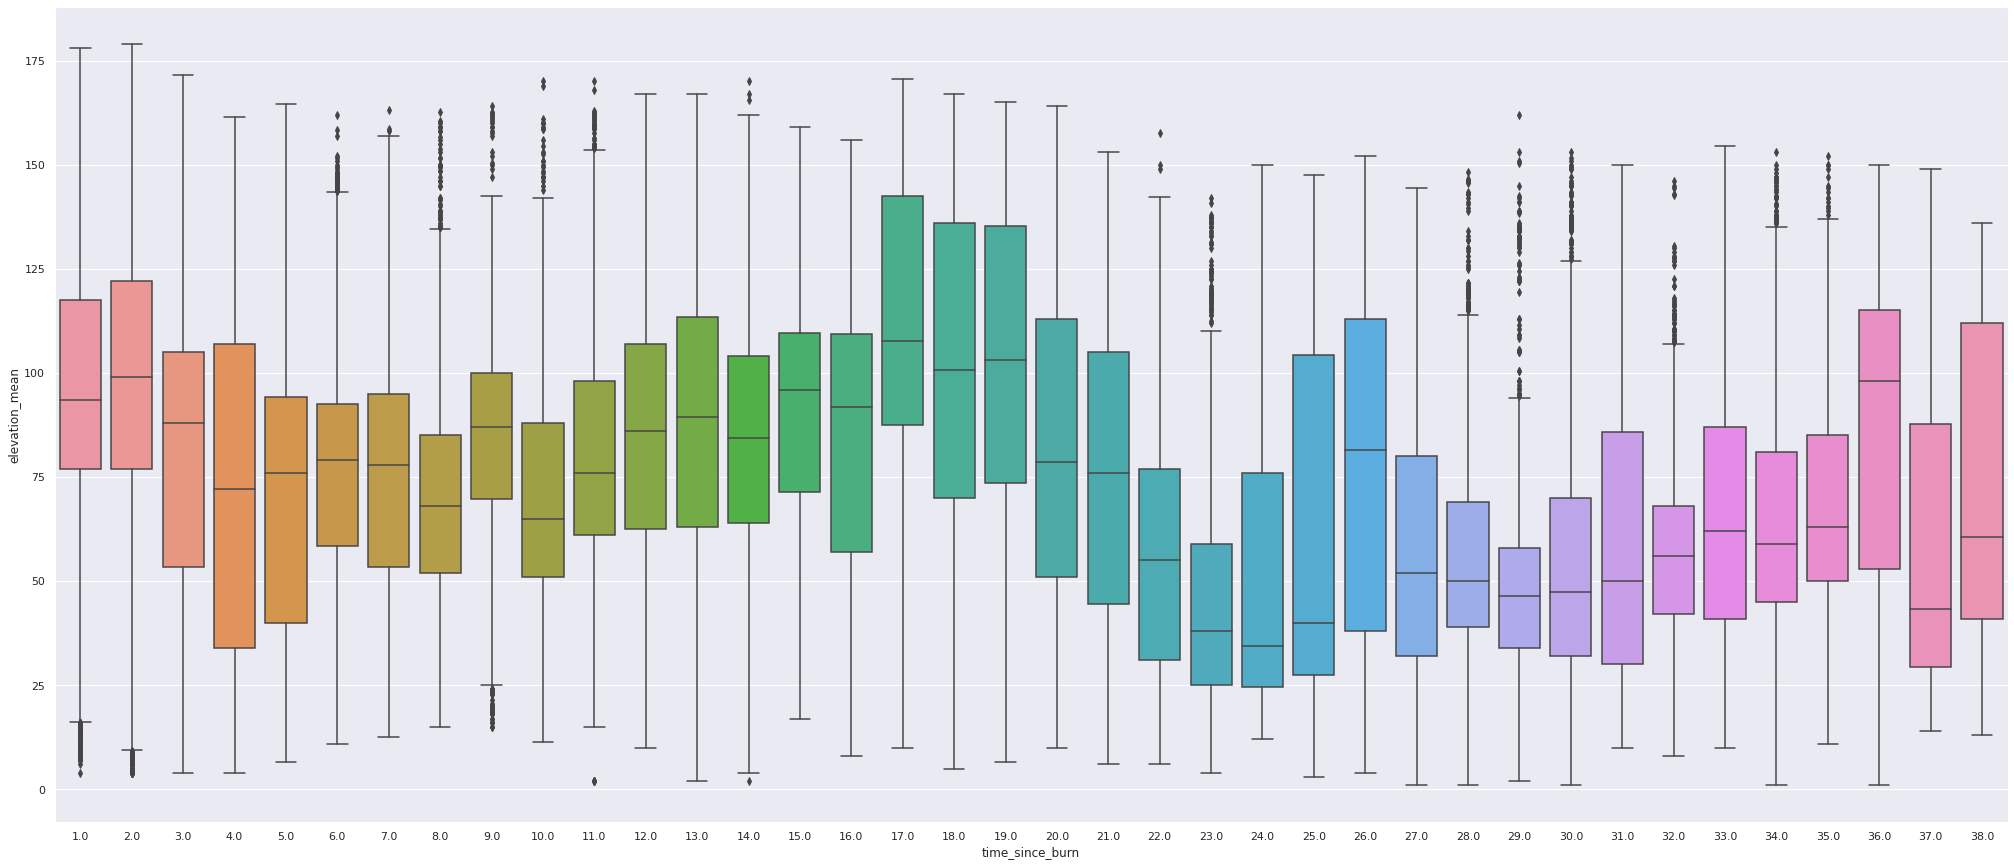

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_burned_trees[gedi_burned_trees.burn_severity_median==2], x='time_since_burn', y="elevation_mean", ax=ax)

### AGBD vs Terrain

(0.0, 2000.0)

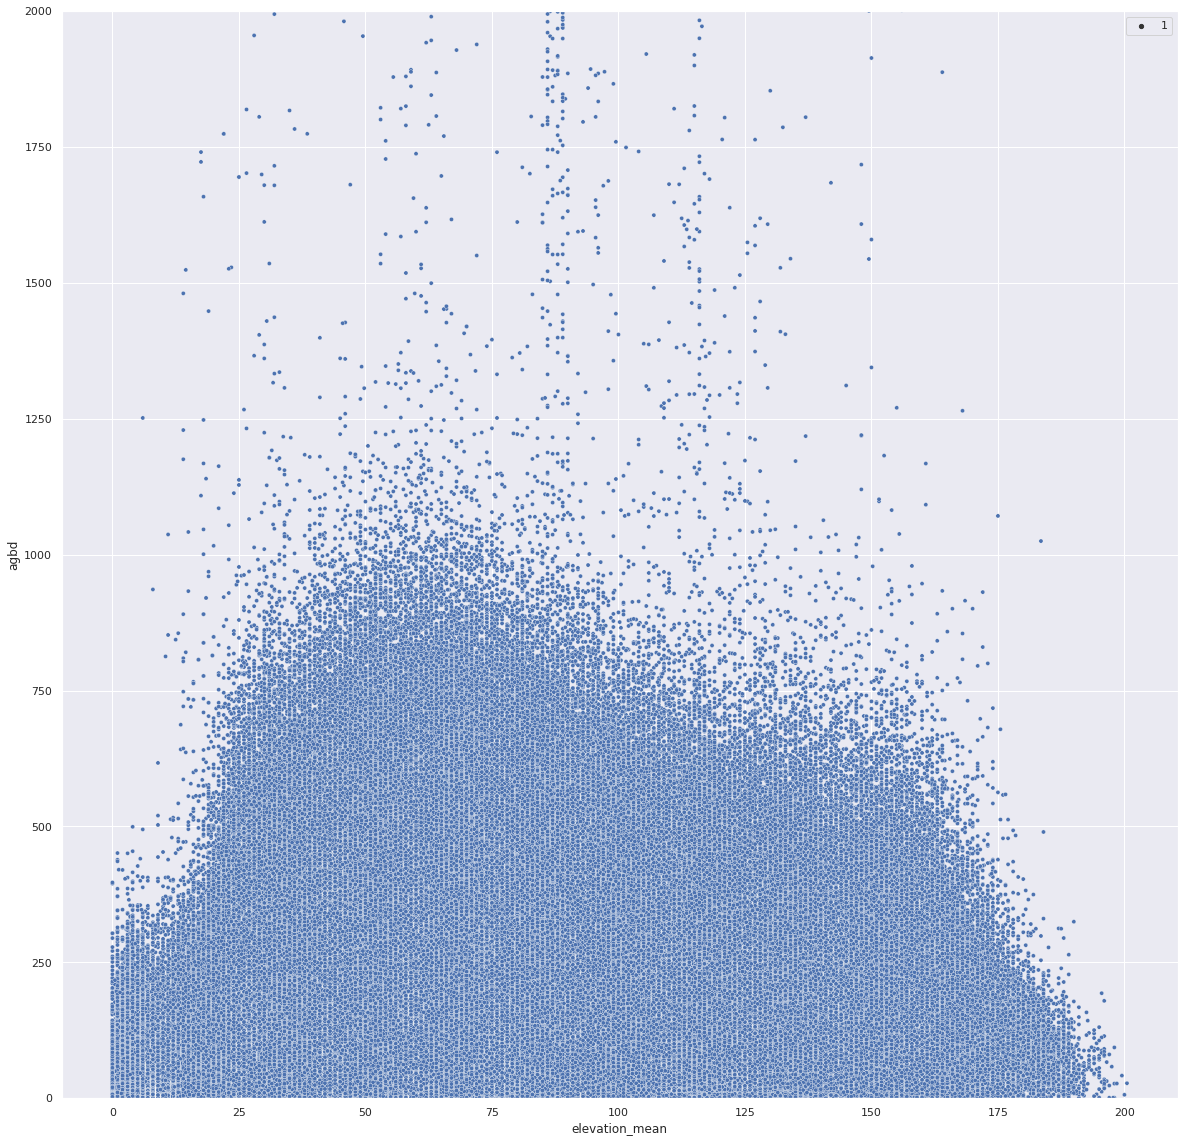

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.scatterplot(gedi_unburned_trees, x='elevation_mean', y="agbd", ax=ax, size=1)
ax.set_ylim((0, 2000))

(0.0, 2000.0)

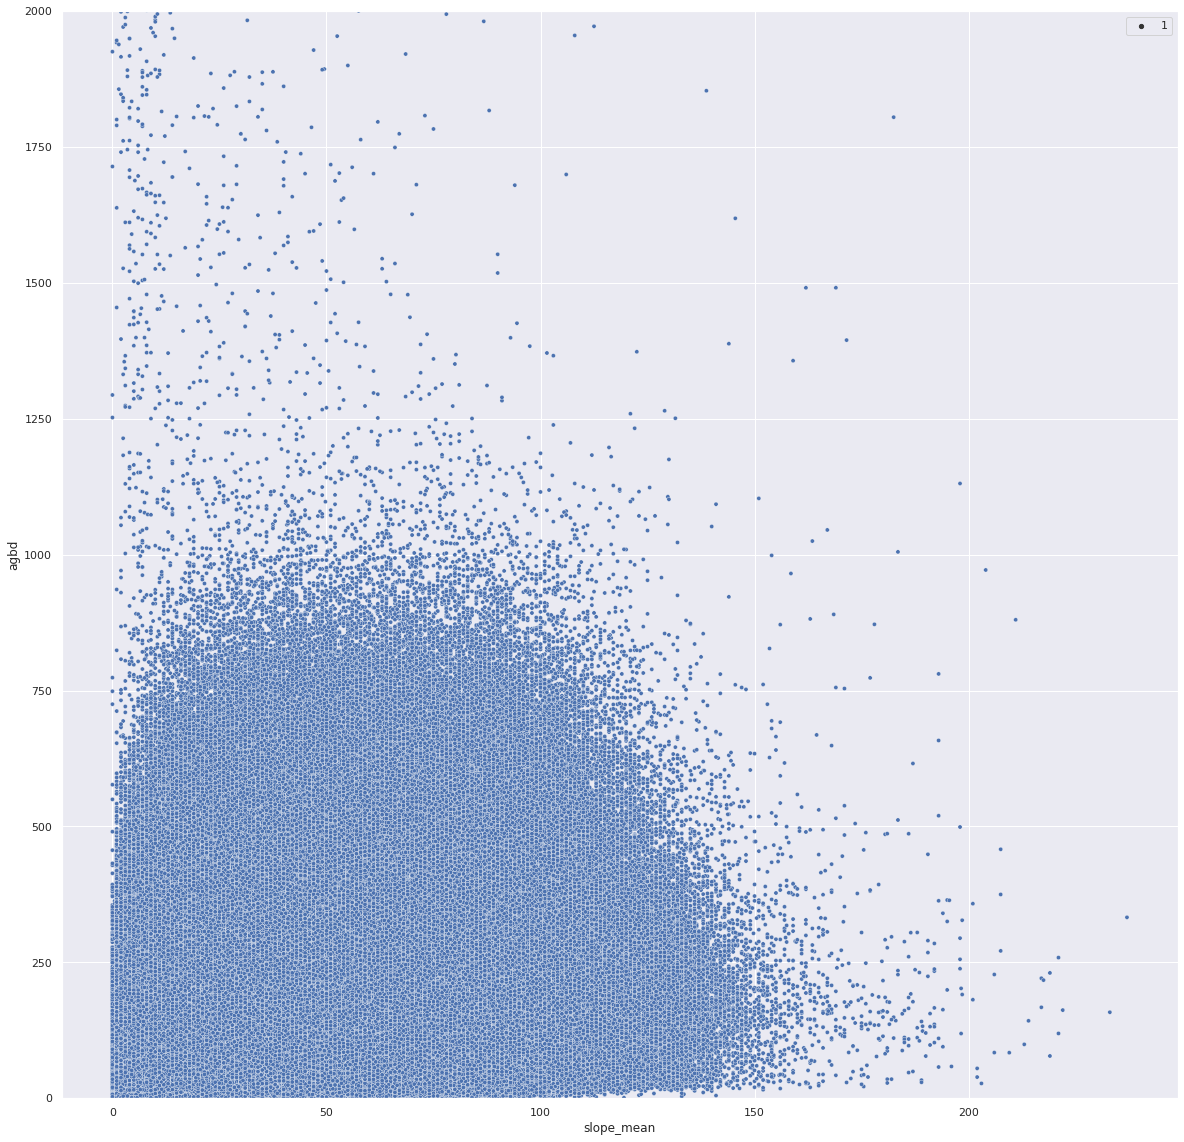

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.scatterplot(gedi_unburned_trees, x='slope_mean', y="agbd", ax=ax, size=1)
ax.set_ylim((0, 2000))

(0.0, 2000.0)

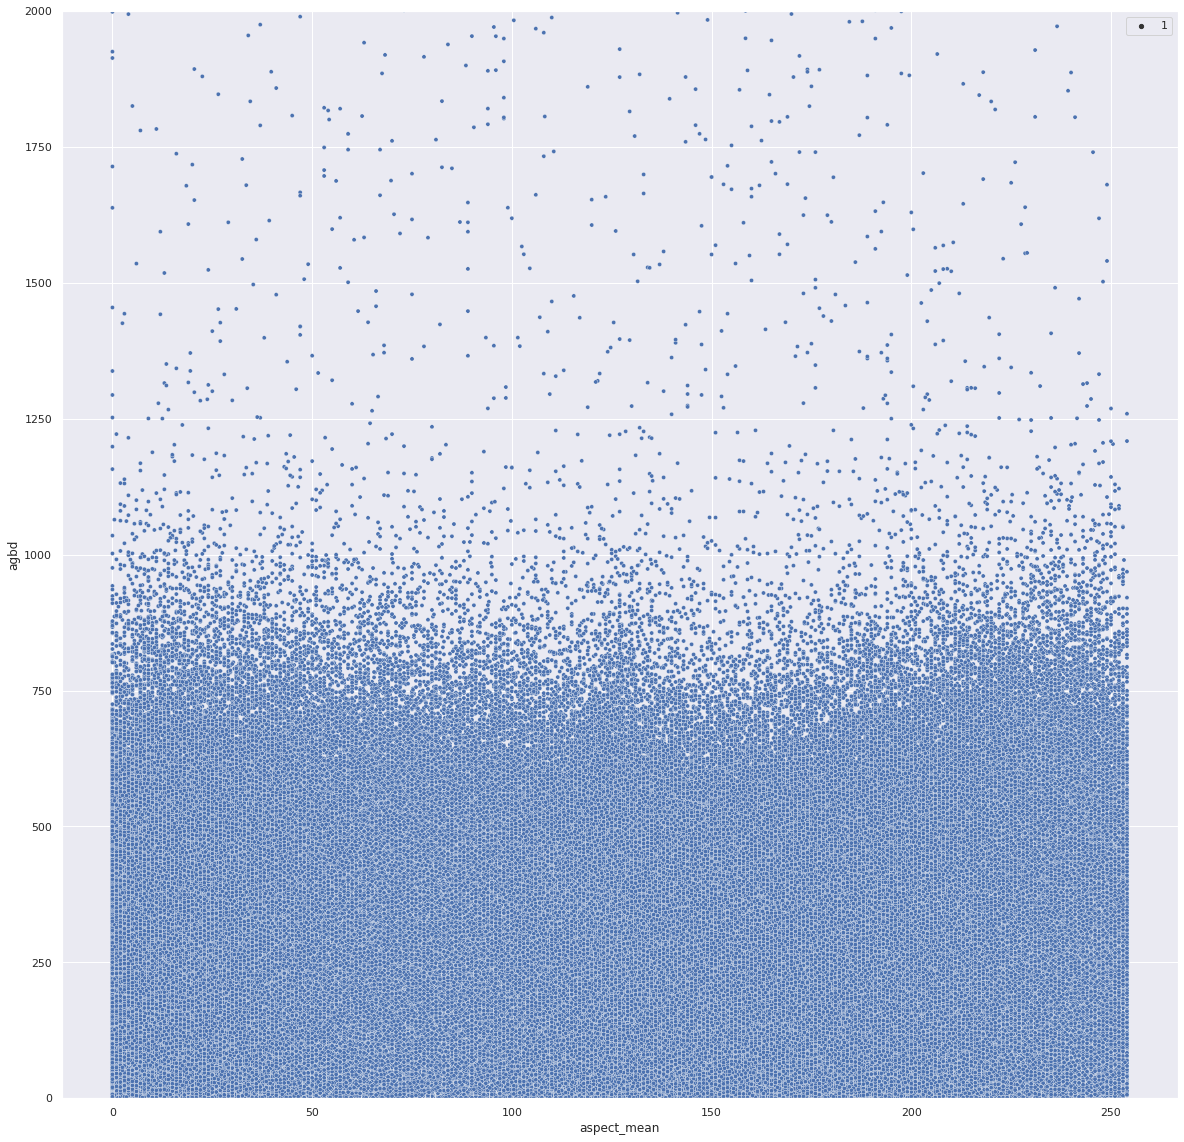

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.scatterplot(gedi_unburned_trees, x='aspect_mean', y="agbd", ax=ax, size=1)
ax.set_ylim((0, 2000))

(0.0, 2000.0)

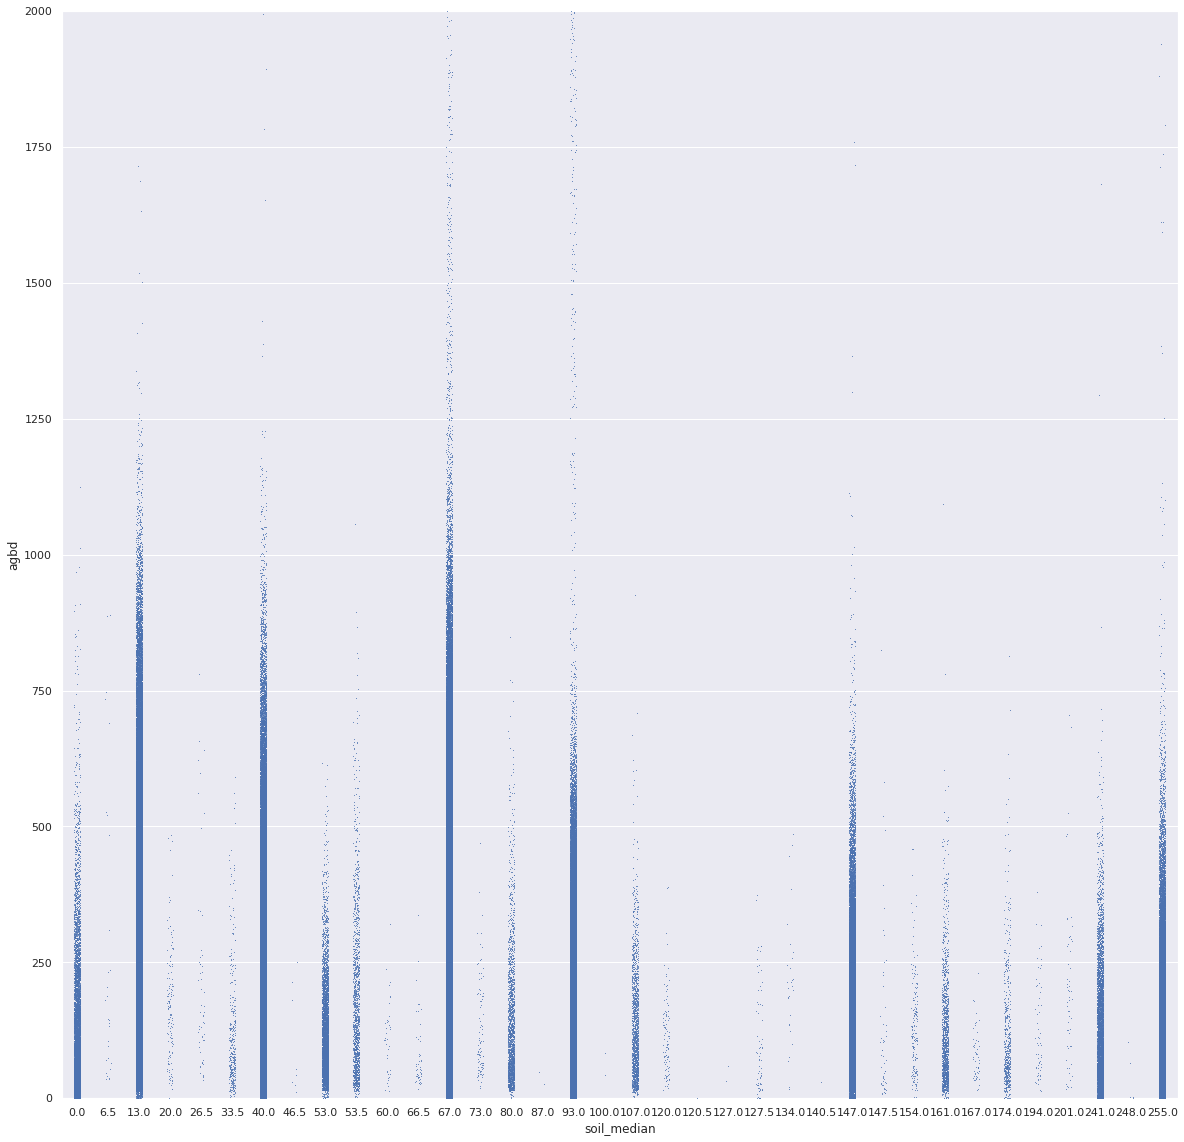

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.stripplot(gedi_unburned_trees, x='soil_median', y="agbd", ax=ax, size=1)
ax.set_ylim((0, 2000))

(0.0, 1000.0)

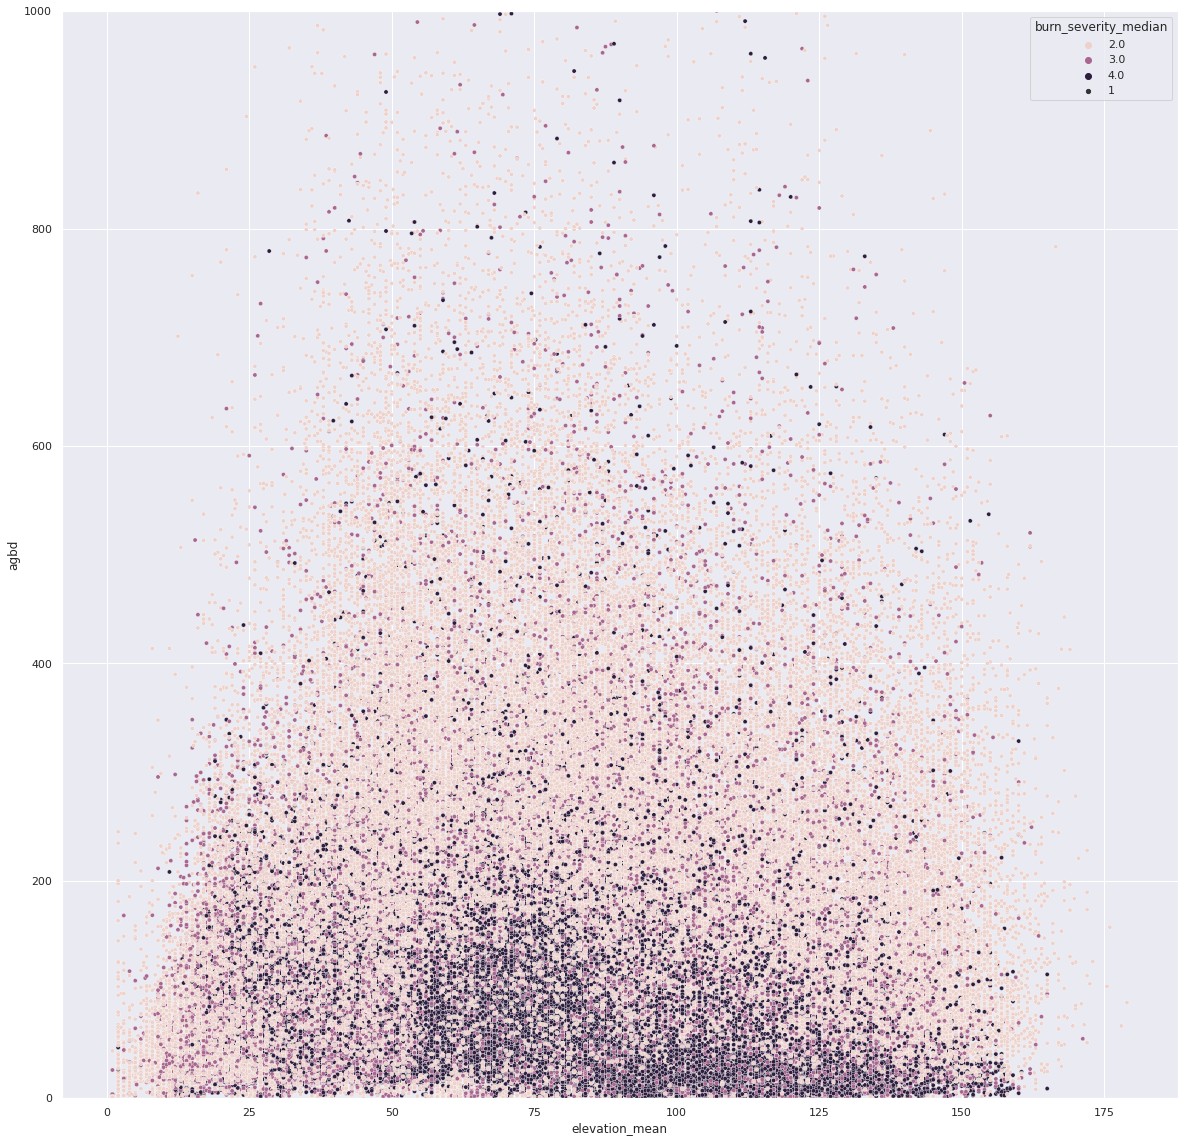

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.scatterplot(gedi_burned_trees, x='elevation_mean', y="agbd", ax=ax, size=1, hue='burn_severity_median')
ax.set_ylim((0, 1000))

<AxesSubplot: xlabel='elevation_mean', ylabel='rel_agbd'>

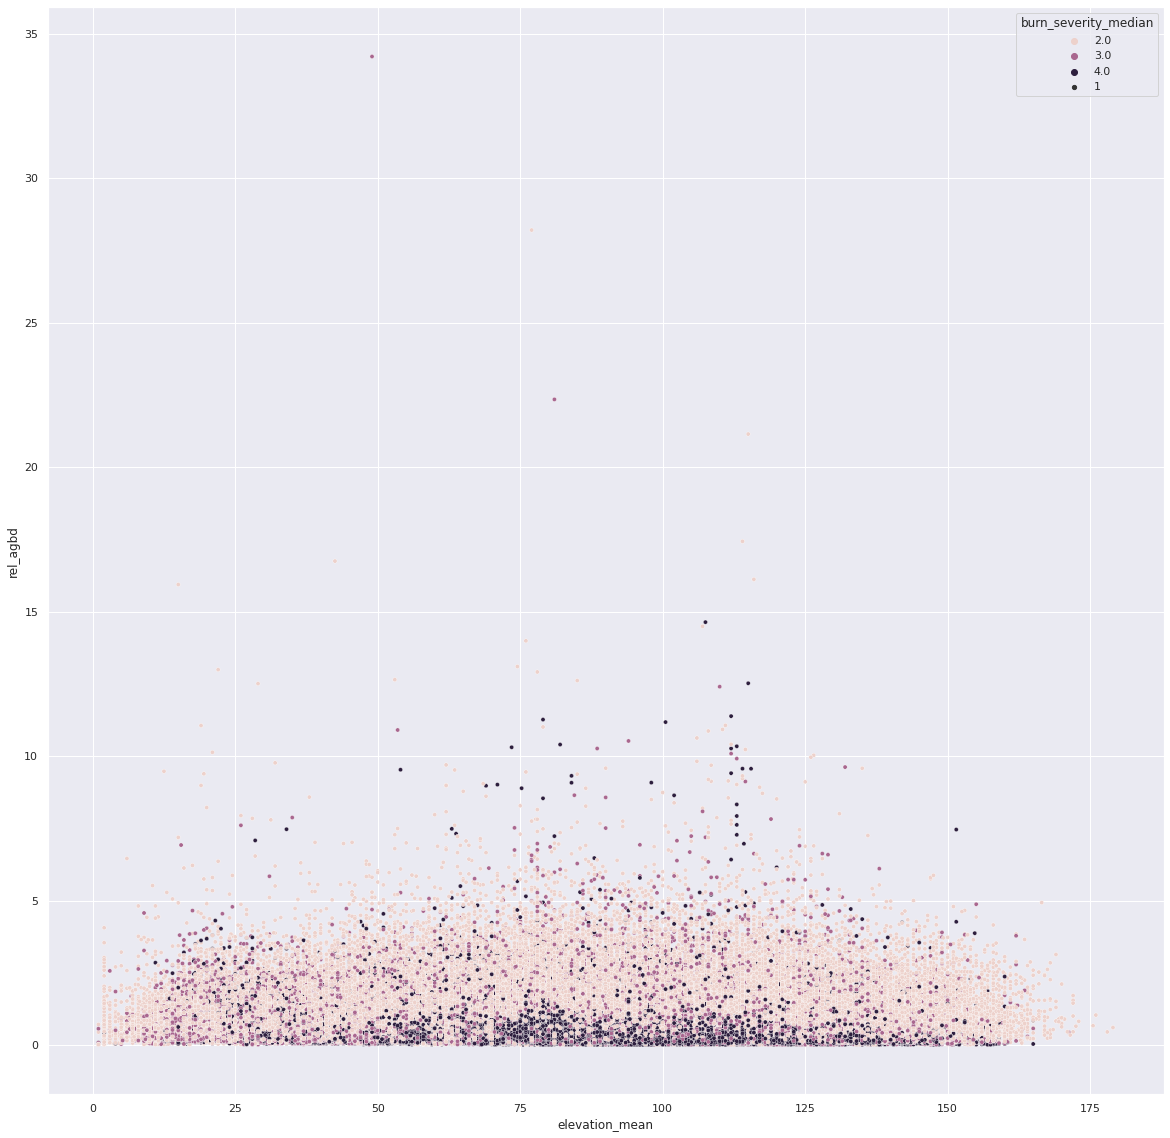

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.scatterplot(result[result.burn_severity_median.isin([2, 3, 4])], x='elevation_mean', y="rel_agbd", ax=ax, size=1, hue='burn_severity_median')

In [73]:
gedi_unburned_trees[['agbd', 'elevation_mean', 'elevation_mean']].corr()

agbd  elevation_mean
agbd            1.000000        0.222745
elevation_mean  0.222745        1.000000

In [74]:
gedi_unburned_trees[['agbd', 'elevation_mean', 'slope_mean', 'aspect_mean', 'soil_median']].corr()

agbd  elevation_mean  slope_mean  aspect_mean  soil_median
agbd            1.000000        0.222745    0.256367    -0.037513    -0.123954
elevation_mean  0.222745        1.000000    0.043194    -0.039616     0.209818
slope_mean      0.256367        0.043194    1.000000     0.033776    -0.225046
aspect_mean    -0.037513       -0.039616    0.033776     1.000000    -0.033903
soil_median    -0.123954        0.209818   -0.225046    -0.033903     1.000000

In [75]:
gedi_burned_trees[['agbd', 'elevation_mean', 'slope_mean', 'aspect_mean', 'soil_median', 'burn_severity_median', 'time_since_burn']].corr()

agbd  elevation_mean  slope_mean  aspect_mean  \
agbd                  1.000000        0.018345    0.207148    -0.012626   
elevation_mean        0.018345        1.000000   -0.045150    -0.038432   
slope_mean            0.207148       -0.045150    1.000000     0.027766   
aspect_mean          -0.012626       -0.038432    0.027766     1.000000   
soil_median          -0.104919        0.222319   -0.194823    -0.015243   
burn_severity_median -0.374017       -0.035112   -0.020969    -0.004363   
time_since_burn      -0.159541       -0.212796   -0.135753     0.008824   

                      soil_median  burn_severity_median  time_since_burn  
agbd                    -0.104919             -0.374017        -0.159541  
elevation_mean           0.222319             -0.035112        -0.212796  
slope_mean              -0.194823             -0.020969        -0.135753  
aspect_mean             -0.015243             -0.004363         0.008824  
soil_median              1.000000             -0.014241        -0.046522  
burn_severity_median    -0.014241              1.000000         0.157029  
time_since_burn         -0.046522              0.157029         1.000000

In [76]:
gedi_burned_trees[gedi_burned_trees.burn_severity_median==2][['agbd', 'elevation_mean', 'slope_mean', 'aspect_mean', 'soil_median', 'burn_severity_median', 'time_since_burn']].corr()

agbd  elevation_mean  slope_mean  aspect_mean  \
agbd                  1.000000        0.020708    0.219899    -0.026271   
elevation_mean        0.020708        1.000000   -0.125735    -0.032823   
slope_mean            0.219899       -0.125735    1.000000     0.039040   
aspect_mean          -0.026271       -0.032823    0.039040     1.000000   
soil_median          -0.151060        0.206474   -0.256976    -0.017115   
burn_severity_median       NaN             NaN         NaN          NaN   
time_since_burn      -0.192622       -0.274878   -0.094651     0.017213   

                      soil_median  burn_severity_median  time_since_burn  
agbd                    -0.151060                   NaN        -0.192622  
elevation_mean           0.206474                   NaN        -0.274878  
slope_mean              -0.256976                   NaN        -0.094651  
aspect_mean             -0.017115                   NaN         0.017213  
soil_median              1.000000                   NaN        -0.003572  
burn_severity_median          NaN                   NaN              NaN  
time_since_burn         -0.003572                   NaN         1.000000

In [77]:
gedi_burned_trees[gedi_burned_trees.burn_severity_median==3][['agbd', 'elevation_mean', 'slope_mean', 'aspect_mean', 'soil_median', 'burn_severity_median', 'time_since_burn']].corr()

agbd  elevation_mean  slope_mean  aspect_mean  \
agbd                  1.000000        0.041552    0.254682    -0.018750   
elevation_mean        0.041552        1.000000   -0.019924    -0.044232   
slope_mean            0.254682       -0.019924    1.000000     0.035751   
aspect_mean          -0.018750       -0.044232    0.035751     1.000000   
soil_median          -0.072419        0.311664   -0.166488    -0.032189   
burn_severity_median       NaN             NaN         NaN          NaN   
time_since_burn      -0.128406       -0.250375   -0.151508    -0.017468   

                      soil_median  burn_severity_median  time_since_burn  
agbd                    -0.072419                   NaN        -0.128406  
elevation_mean           0.311664                   NaN        -0.250375  
slope_mean              -0.166488                   NaN        -0.151508  
aspect_mean             -0.032189                   NaN        -0.017468  
soil_median              1.000000                   NaN        -0.069827  
burn_severity_median          NaN                   NaN              NaN  
time_since_burn         -0.069827                   NaN         1.000000

In [78]:
gedi_burned_trees[gedi_burned_trees.burn_severity_median==4][['agbd', 'elevation_mean', 'slope_mean', 'aspect_mean', 'soil_median', 'burn_severity_median', 'time_since_burn']].corr()

agbd  elevation_mean  slope_mean  aspect_mean  \
agbd                  1.000000       -0.120476    0.220960     0.015306   
elevation_mean       -0.120476        1.000000    0.078389    -0.042985   
slope_mean            0.220960        0.078389    1.000000     0.006344   
aspect_mean           0.015306       -0.042985    0.006344     1.000000   
soil_median          -0.111827        0.168539   -0.112363    -0.000908   
burn_severity_median       NaN             NaN         NaN          NaN   
time_since_burn       0.052625       -0.109677   -0.174095     0.018302   

                      soil_median  burn_severity_median  time_since_burn  
agbd                    -0.111827                   NaN         0.052625  
elevation_mean           0.168539                   NaN        -0.109677  
slope_mean              -0.112363                   NaN        -0.174095  
aspect_mean             -0.000908                   NaN         0.018302  
soil_median              1.000000                   NaN        -0.071865  
burn_severity_median          NaN                   NaN              NaN  
time_since_burn         -0.071865                   NaN         1.000000